# FIFA 20 Ultimate Team
## Overall and position area prediction
Dalam permainan di FIFA 20 Ultimate Team, setiap pemain memiliki nilai overall yang skalanya 0-99 dan overall ini ditentukan dari skill yang terdiri dari pace, dribbling, shooting, passing, defending, physicality. Sedangkan goalkeeper tidak memiliki kemampuan ini, seorang goalkeeper memiliki kemampuan sendiri seperti reflexes, diving, kick, dan masih banyak lagi. Skill-skill ini merupakan nilai keseluruhan yang ditentukan oleh fifa berdasarkan skill-skill yang lebih mendalamnya. Sehingga dalam hal ini kita akan melakukan prediksi dengan features yang telah disebutkan. Kemudian melihat correlation dan pengaruh terhadap overall.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import welch_anova, pairwise_gameshowell, pairwise_ttests, anova
from scipy.stats import chi2,ttest_ind, mannwhitneyu, levene,bartlett, f_oneway,kruskal, shapiro, anderson, normaltest, chisquare
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

C:\Users\Lenovo\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.2, the latest is 0.3.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
fifa=pd.read_csv('fut_bin20_players.csv')
fifa.drop(['futbin_id','specialities','origin'], axis=1, inplace=True)
fifa=pd.get_dummies(data=fifa, drop_first=True, columns=['pref_foot'])
fifa.info()

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18775 entries, 0 to 18774
Data columns (total 92 columns):
player_name             18775 non-null object
player_extended_name    18775 non-null object
quality                 18775 non-null object
revision                18409 non-null object
overall                 18775 non-null int64
club                    18775 non-null object
league                  18775 non-null object
nationality             18775 non-null object
position                18775 non-null object
age                     18775 non-null int64
date_of_birth           18775 non-null object
height                  18775 non-null int64
weight                  18775 non-null int64
intl_rep                17047 non-null float64
added_date              18775 non-null object
pace                    16791 non-null float64
pace_acceleration       18672 non-null float64
pace_sprint_speed       18672 non-null float64
dribbling               16791 non-null float64
drib_agility    

## Functions

In [3]:
#defined area per position 
def area(col):
    col=str(col)
    if col=='ST' or col=='CF':
        return 'Center Forward'
    elif col=='LW' or col=='RW' or col=='RF' or col=='LF':
        return 'Wing Forward'
    elif col=='RM' or col=='LM':
        return 'Wing Middle'
    elif col=='CAM' or col=='CM' or col=='CDM':
        return 'Center Middle'
    elif col=='LB' or col=='RB' or col=='RWB' or col=='LWB':
        return 'Wing Back'
    elif col=='CB':
        return 'Center Back'
    else:
        return 'Goalkeeper'

#just to get the quality card
def quality(col):
    if 'Gold' in col:
        return 'Gold'
    elif 'Silver' in col:
        return 'Silver'
    elif 'Bronze' in col:
        return 'Bronze'
    else:
        return col

#bootstrap algorithm
#Hal ini untuk melihat range
def make_bootstrap(boot,data,req):
    ci=0.95
    last=[]
    n=len(data)
    for i in range(boot):
        sampling=data.sample(n, replace=True)
        last.append(sampling.mean())
    isi=np.sort(np.array(last))
    level=((1-ci)/2)
    atas=1-level
    batas=[isi[round(level*boot)], isi[round(atas*boot)]]
    if req=='isi':
        return last
    else:
        return batas
    
#Melihat data-data null untuk setiap featurenya
def nullity(data):
    df=pd.DataFrame(columns=['dataFeatures','dataType','null','nullPct','unique','uniqueSample'])
    df['dataFeatures']=data.columns
    df['dataType']=[i for i in data.dtypes]
    df['null']=df['dataFeatures'].apply(lambda x: sum(data[x].isna()))
    df['nullPct']=df['null'].apply(lambda x: round((x/len(data))*100,2))
    df['unique']=df['dataFeatures'].apply(lambda x: len(data[~(data[x].isna())][x].unique()))
    return df

## Data Cleaning
Pada FIFA 20, goalkeeper tidak memiliki kemampuan seperti pace, dribbling dan kemampuan lain yang hanya dimiliki oleh pemain selain goalkeeper, sehingga goalkeeper memiliki nilai pace atau dribbling Nan. Karena disini hanya beberapa feature yang digunakkan ke dalam model, maka data null yang lainnya tidak perlu diperhatikan. Terdapat feature baru yang ditambahkan berupa position area dimana menjelaskan area posisi setiap pemain berbeda dengan position yang menggambarkan posisi spesifik dari setiap pemain.

In [4]:
print(nullity(fifa).loc[:40])
print(nullity(fifa).loc[41:])

            dataFeatures dataType  null  nullPct  unique uniqueSample
0            player_name   object     0     0.00   12968          NaN
1   player_extended_name   object     0     0.00   16383          NaN
2                quality   object     0     0.00       6          NaN
3               revision   object   366     1.95      53          NaN
4                overall    int64     0     0.00      52          NaN
5                   club   object     0     0.00     653          NaN
6                 league   object     0     0.00      45          NaN
7            nationality   object     0     0.00     159          NaN
8               position   object     0     0.00      17          NaN
9                    age    int64     0     0.00      53          NaN
10         date_of_birth   object     0     0.00    6036          NaN
11                height    int64     0     0.00      50          NaN
12                weight    int64     0     0.00      56          NaN
13              intl

In [5]:
fifa['position_area']=fifa['position'].apply(area)
fifa['quality']=fifa['quality'].apply(quality)

In [6]:
for i in fifa[fifa['position']=='GK'].index:
    fifa['pace'][i]=0
    fifa['shooting'][i]=0
    fifa['dribbling'][i]=0
    fifa['passing'][i]=0
    fifa['defending'][i]=0
    fifa['physicality'][i]=0

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing t

## Exploratory Data Analysis

### Melihat correlation untuk setiap features yang akan digunakkan dalam model

Terdapat beberapa feature yang memiliki hubungan yang cukup kuat dengan kolom lainnya. Hal ini dapat mempengaruhi prediksi dengan metode Linear Regression.

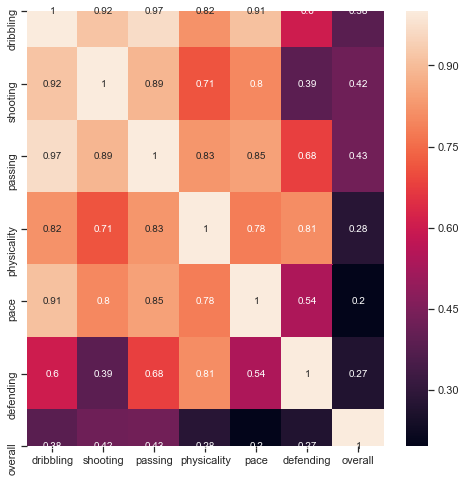

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(fifa[['dribbling','shooting','passing','physicality','pace','defending','overall']].corr(), annot=True)

### Quality berdasarkan overall
Disini dapat dilihat nilai overall terkecil dan terbesar untuk setial qualitynya yang terdiri dari Gold, Silver, dan Bronze. Hal ini menunjukkan ketika quality dari setiap pemain juga bergantung dengan overallnya. Lebih mudah lagi jika melihat persebaran data overall untuk setiap qualitynya dengan grafik boxplot.

In [8]:
for i in fifa['quality'].unique():
    print(i.upper()+' :')
    print('Max {}\nMin {}\n'.format(fifa[fifa['quality']==i]['overall'].max(), fifa[fifa['quality']==i]['overall'].min()))

GOLD :
Max 99
Min 75

SILVER :
Max 74
Min 65

BRONZE :
Max 64
Min 48



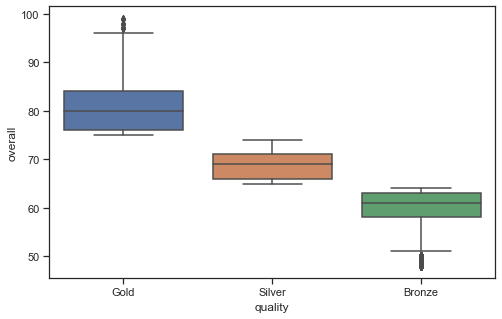

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(data=fifa, x='quality', y='overall')
sns.set_style(style='darkgrid')

#### Skill untuk setiap position area
Disini kita dapat melihat persebaran nilai skill untuk setiap pemain di position area tertentu, dan kita mengerti tugas untuk setiap position area

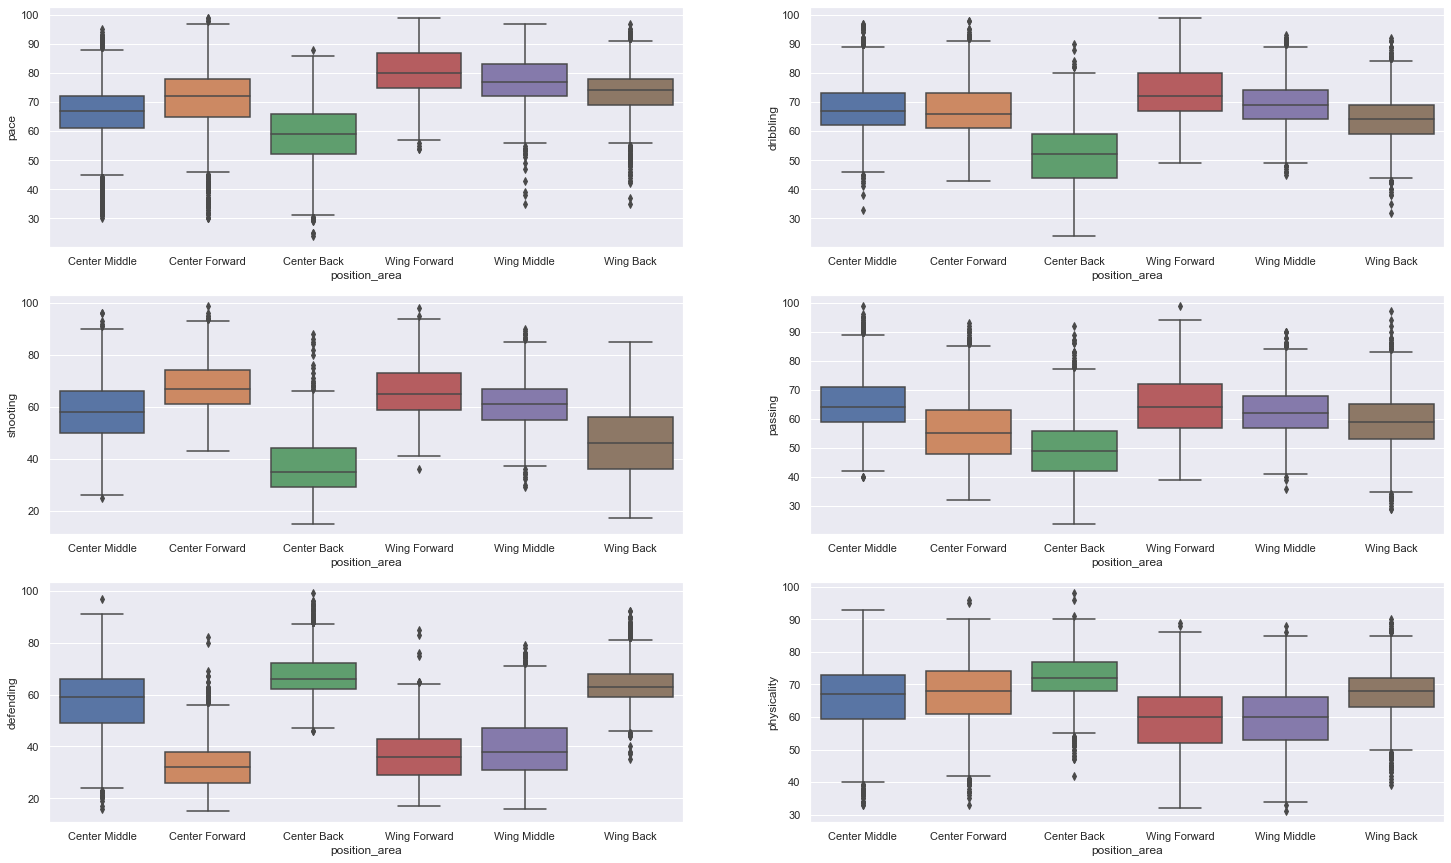

In [10]:
skill=['pace','dribbling','shooting','passing','defending','physicality']
plt.figure(figsize=(25,15))
for i,j in enumerate(skill):
    plt.subplot(3,2,i+1)
    sns.boxplot(data=fifa[(fifa['position']!='GK')], x='position_area', y=j)

#### Melihat range untuk posisi area di tengah dan wing


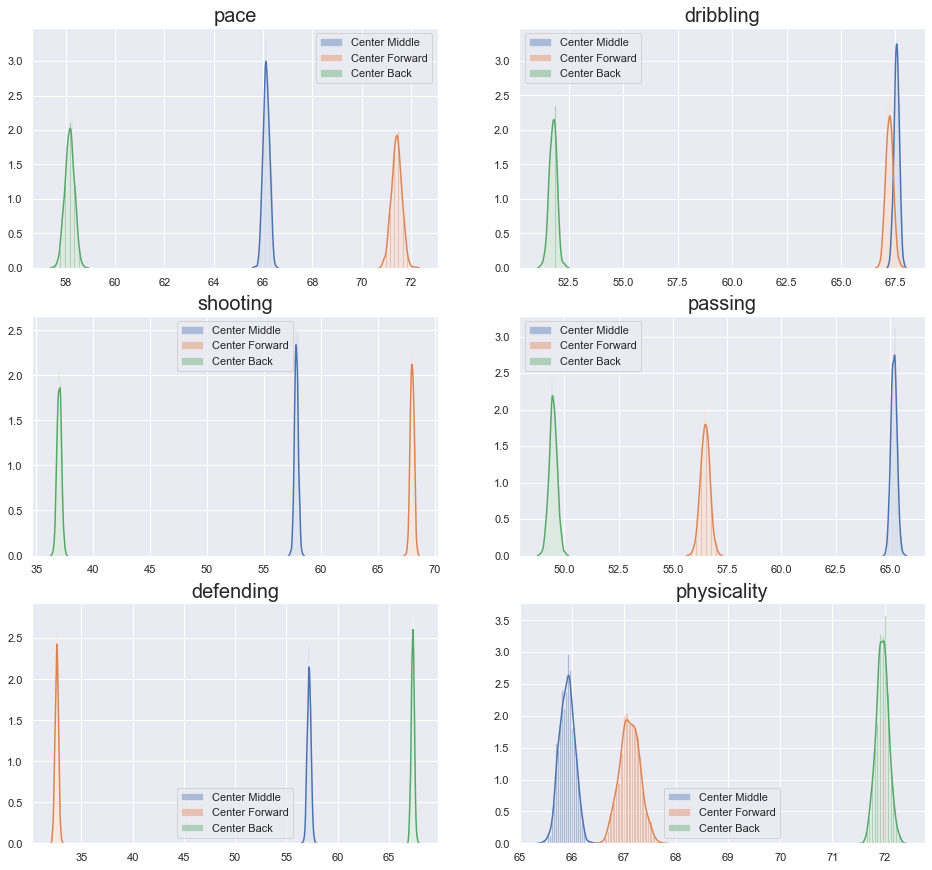

In [11]:
#CENTER
plt.figure(figsize=(16,15))
for num, skil in enumerate(skill):
    plt.subplot(3,2,num+1)
    for posisi in [i for i in fifa['position_area'].unique() if 'Center' in i]:
        sns.distplot(make_bootstrap(1000,fifa[fifa['position_area']==posisi][skil],'isi'), label=posisi)
    plt.title(skil, fontsize=20)
    plt.legend()

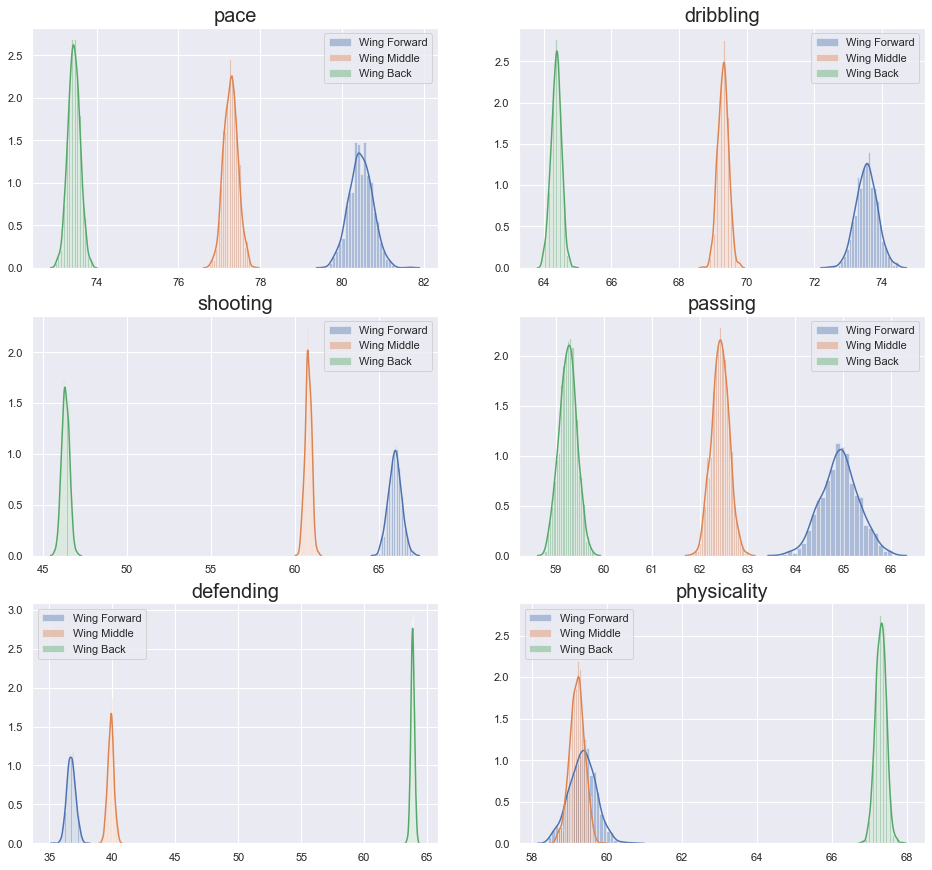

In [12]:
#WINGER
plt.figure(figsize=(16,15))
for num, skil in enumerate(skill):
    plt.subplot(3,2,num+1)
    for posisi in [i for i in fifa['position_area'].unique() if 'Wing' in i]:
        sns.distplot(make_bootstrap(1000,fifa[fifa['position_area']==posisi][skil],'isi'), label=posisi)
    plt.title(skil, fontsize=20)
    plt.legend()

#### Range keadaan fisik (umur, tinggi, dan berat) untuk setiap quality
Hal ini menunjukkan seiring meningkatnya umur, tinggi, dan berat, maka quality yang dimiliki juga mendekati Gold. Namun terdapat daerah yang beririsan untuk tinggi pemain.

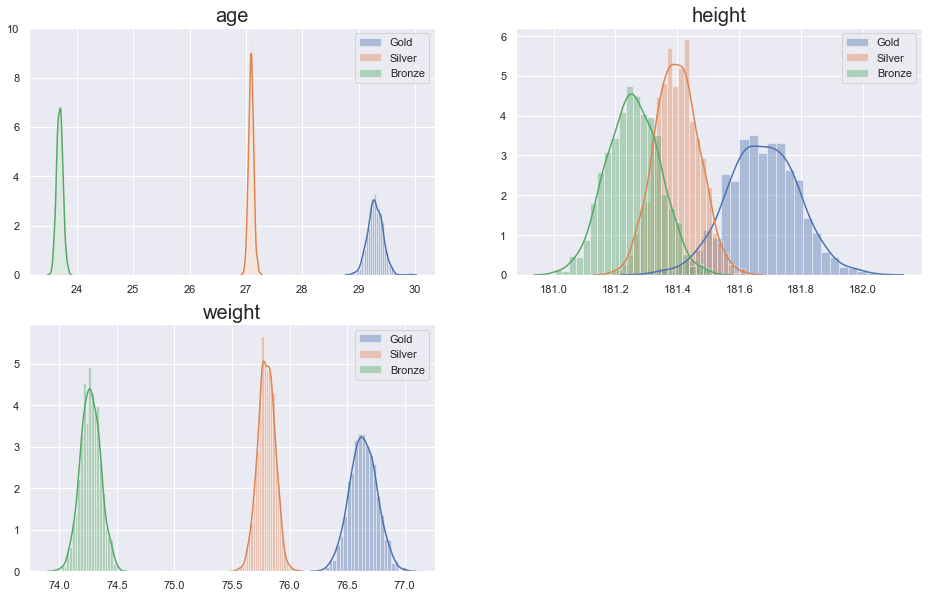

In [13]:
plt.figure(figsize=(16,10))
for num,i in enumerate(['age','height','weight']):
    plt.subplot(2,2,num+1)
    for j in fifa['quality'].unique():
        sns.distplot(make_bootstrap(1000, fifa[fifa['quality']==j][i], 'isi'), label=j)
        plt.legend()
    plt.title(i, fontsize=20)

# Prediction
Pada tahap ini, kita akan melakukan splitting data, training data, predict dan evaluasi model. Kemudian kita akan membandingkan setiap metodenya. 

- Overall predictions : Linear Regression, Ridge Regression, Lasso Regression, dan Decision Tree Regressor
- Position area predictions : Decision Tree Classifier dan Random Forest

## Overall prediction

In [14]:
over=fifa['overall']
posisi=fifa['position_area']
area=fifa['position_area']
data_over=fifa[['pace','dribbling','shooting','passing','physicality','defending','age','height','weight']]
data_posisi=fifa[['pace','dribbling','shooting','passing','physicality','defending','pref_foot_Right']]

#### Splitting data

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data_over, over, test_size=0.30, random_state=101)

#### Applying machine learning model and training the data

In [16]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
fifa_linreg=LinearRegression()
fifa_lasso=Lasso(alpha=0.1)
fifa_ridge=Ridge(alpha=0.1)
fifa_dtree_reg=DecisionTreeRegressor()

#Training Data
fifa_linreg.fit(x_train,y_train)
fifa_lasso.fit(x_train,y_train)
fifa_ridge.fit(x_train,y_train)
fifa_dtree_reg.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

#### Predicting

In [17]:
fifa_linreg_predict=fifa_linreg.predict(x_test)
fifa_lasso_predict=fifa_lasso.predict(x_test)
fifa_ridge_predict=fifa_ridge.predict(x_test)
fifa_dtree_reg_predict=fifa_dtree_reg.predict(x_test)

#### Evaluating model

In [18]:
from sklearn import metrics
print('LINEAR REGRESSION')
print('MAE      : ',metrics.mean_absolute_error(y_test, fifa_linreg_predict))
print('MSE      : ',metrics.mean_squared_error(y_test, fifa_linreg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(y_test, fifa_linreg_predict)))
print('R2 Score : ',metrics.r2_score(y_test, fifa_linreg_predict))
print('\nRIDGE REGRESSION')
print('MAE      : ',metrics.mean_absolute_error(y_test, fifa_ridge_predict))
print('MSE      : ',metrics.mean_squared_error(y_test, fifa_ridge_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(y_test, fifa_ridge_predict)))
print('R2 Score : ',metrics.r2_score(y_test, fifa_ridge_predict))
print('\nLASSO REGRESSION')
print('MAE      : ',metrics.mean_absolute_error(y_test, fifa_lasso_predict))
print('MSE      : ',metrics.mean_squared_error(y_test, fifa_lasso_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(y_test, fifa_lasso_predict)))
print('R2 Score : ',metrics.r2_score(y_test, fifa_lasso_predict))
print('\nDECISION TREE REGRESSOR')
print('MAE      : ',metrics.mean_absolute_error(y_test, fifa_dtree_reg_predict))
print('MSE      : ',metrics.mean_squared_error(y_test, fifa_dtree_reg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(y_test, fifa_dtree_reg_predict)))
print('R2 Score : ',metrics.r2_score(y_test, fifa_dtree_reg_predict))

LINEAR REGRESSION
MAE      :  4.618819554856892
MSE      :  35.08076241187858
RMSE     :  5.9229015196843
R2 Score :  0.4912135825938254

RIDGE REGRESSION
MAE      :  4.618819538420763
MSE      :  35.08076206124304
RMSE     :  5.922901490084318
R2 Score :  0.49121358767919376

LASSO REGRESSION
MAE      :  4.618713275297169
MSE      :  35.07567188132268
RMSE     :  5.922471771255873
R2 Score :  0.491287412027001

DECISION TREE REGRESSOR
MAE      :  1.799302579188963
MSE      :  9.679440883874703
RMSE     :  3.1111799825588204
R2 Score :  0.8596162765227159


Kita dapat melihat tidak ada perbedaan signifikan yang terjadi dari hasil prediksi dengan metode Linear, Ridge, dan Lasso Regression. Dengan R-square 0.49 dan hasil prediksi yang mungkin melenceng sebesar 5.92. Berbeda dengan metode Decision Tree Regressor, hasil prediksinya memiliki R-square 0.86 artinya 86% garis ini dapat merepresentasikan data. Kemudian hasil prediksinya bisa melenceng sebesar 3.06. Sehingga, hasil prediksi terbaik diperoleh dengan metode Decision Tree Regressor

#### Applying machine learning model and training the data

## Position area prediction

#### Splitting Data

In [19]:
X_train,X_test,Y_train,Y_test=train_test_split(data_posisi, posisi, test_size=0.30, random_state=101)

#### Applying machine learning and training the data

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
fifa_dtree=DecisionTreeClassifier()
fifa_rfc=RandomForestClassifier()

#Training Data
fifa_dtree.fit(X_train,Y_train)
fifa_rfc.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Predicting

In [21]:
fifa_dtree_predict=fifa_dtree.predict(X_test)
fifa_rfc_predict=fifa_rfc.predict(X_test)

In [22]:
from sklearn.metrics import classification_report
print('\t\t\tDecision Tree'.upper())
print(classification_report(Y_test,fifa_dtree_predict)+'\n\n')
print('\t\t\tRandom Forest'.upper()) 
print(classification_report(Y_test,fifa_rfc_predict)) 

			DECISION TREE
                precision    recall  f1-score   support

   Center Back       0.81      0.82      0.82       973
Center Forward       0.82      0.80      0.81       857
 Center Middle       0.68      0.69      0.69      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.68      0.67      0.67       836
  Wing Forward       0.33      0.39      0.36       245
   Wing Middle       0.48      0.45      0.47       688

      accuracy                           0.72      5633
     macro avg       0.69      0.69      0.69      5633
  weighted avg       0.72      0.72      0.72      5633



			RANDOM FOREST
                precision    recall  f1-score   support

   Center Back       0.88      0.89      0.88       973
Center Forward       0.86      0.89      0.87       857
 Center Middle       0.74      0.81      0.78      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.80      0.78      0.79       836
  Wing F

Model Decision Tree Classifier menunjukkan prediksi yang memiliki akurasi 72%, dan ini cukup bagus melihat semua posisi memiliki presisi dan recall diatas 70% kecuali untuk area posisi di Wing. Sedangkan untuk model Random Forest Classifier, akurasinya meningkat menjadi 80% dan seluruh presisi dan recall meningkat drastis dibandingkan dengan model Decision Tree Classifier, sehingga dapat dikatakan model Random Forest Classifier merupakan model terbaik untuk melakukan prediksi posisi area. Terdapat beberapa hal yang cukup ganjil dimana kedua model ini tidak dapat mengidentifikasi posisi area Wing Forward dan Wing Middle. Oleh karena itu, akan ditelusuri lebih lanjut perbedaan posisinya.

## Wing Middle vs Wing Forward
Dengan metode bootstrap, kita akan melihat range untuk setiap skill yang dimiliki. Jika kita lihat grafik distribusi dibawah skill pace, dribbling, passing, shooting rangenya lebih besar pada Wing Forward. Hal ini dikarenakan Wing Forward memiliki tugas berlari dari samping lapangan untuk melewati lawan dan memberikan operan atau crossing ke kotak penalti lawan agar sang penyerang dapat mencetak gol, biasanya Wing Forward dikategorikan sebagai penyerang. Oleh karena itu, defendingnya lebih kecil nilai rangenya daripada Wing Middle karena Wing Middle melakukan setengah tugas dari Wing Forward dan Wing Back. Sehingga memiliki nilai defence yang lebih besar. Namun, kedua posisi ini sama dan biasanya jika sudah ada Wing Middle tidak ada Wing Forward dan sebaliknya. Sehingga, kedua model tidak dapat membedakan Wing Forward dan Wing Middle. Tapi, model tetap memiliki presisi dan recall yang tidak terlalu buruk

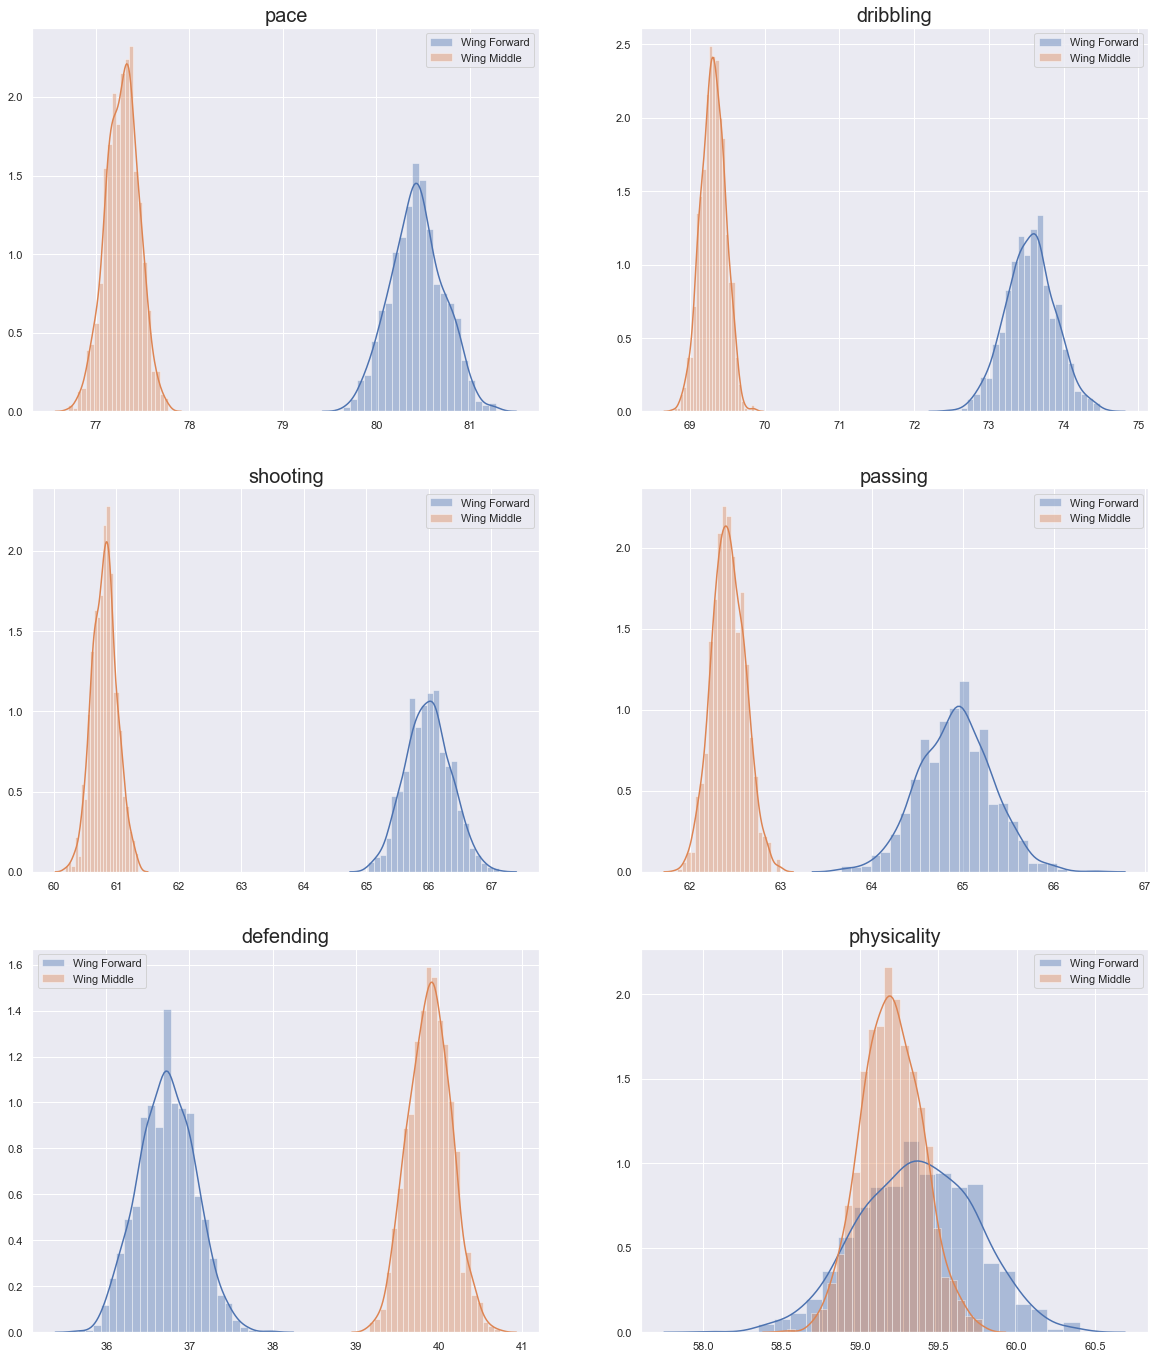

In [23]:
plt.figure(figsize=(20,24))
for num,i in enumerate(skill):
    plt.subplot(3,2,num+1)
    sns.distplot(make_bootstrap(1000,fifa[fifa['position_area']=='Wing Forward'][i],'isi'), label='Wing Forward')
    sns.distplot(make_bootstrap(1000,fifa[fifa['position_area']=='Wing Middle'][i],'isi'), label='Wing Middle')
    plt.title(i, fontsize=20)
    plt.legend()